In [1]:
%matplotlib inline
import numpy as np
import torch
import random
import datetime
import tensorboardX
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.distributions as tchd 
from torch import nn
from copy import deepcopy
from collections import defaultdict
from collections import OrderedDict as odict
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Theory

To be completed

**Note**: This notebook only focuses on defining problems where the excess variance is visibly a problem in ordinary training. You will not find any solutions for these problems here (e.g., bootstrapping, double-sampling, etc.).

In [2]:
device_name = 'cuda:0'
tch_device = torch.device(device_name)
tch_dtype = torch.double
torch.pi = torch.tensor(np.pi).to(device=tch_device, dtype=tch_dtype)

def isscalar(v):
    if torch.is_tensor(v):
        return v.numel() == 1
    else:
        return np.isscalar(v)

### Finding the Exact Smolluchowski Sum

In [3]:
class SMSum:
    def __init__(self, d, n_gpd, x_high, get_kernel):
        """
        Defines the exact Smolluchowski summation over a fixed grid

        Parameters
        ----------
        d: (int) the dimensionality of the points
        
        n_gpd: (int) the number of grid points in each dim
        
        x_high: (torch.tensor) the high boundary in each dim
        
        get_kernel: (callable) a function that takes two tensors 
                with shape (n, d) and returns a (d,) tensor.
        
        """
        
        # n_g -> The total number of points in the d-dim grid
        n_g = n_gpd ** d
        
        x_int_pd = torch.arange(1, n_gpd+1, device=tch_device, dtype=torch.int64)
        x_int = torch.cat([x_int_pd.repeat_interleave(n_gpd**(d-i-1), dim=0).repeat(
            (n_gpd**i,)).reshape(n_g, 1) for i in range(d)], dim=1)
        assert x_int.shape == (n_g, d)

        x_high = x_high
        assert x_high.shape == (d,)
        assert x_high.device == tch_device
        assert x_high.dtype == tch_dtype

        x_flt = x_int * (x_high / n_gpd)
        assert x_flt.shape == (n_g, d)
        
        x_flt_area = x_flt.prod(dim=-1)
        assert x_flt_area.shape == (n_g,)
        
        # integration element volume size dx = dx1 * dx2 * ... * dxd
        assert x_high.shape == (d,)
        dx_vol = torch.prod(x_high / n_gpd).item()
        x_high_area = torch.prod(x_high).item()
        
        # Meshed vectors of x_flt
        x_fmsh1 = x_flt.repeat_interleave(n_g, dim=0).reshape(n_g*n_g, d)
        assert x_fmsh1.shape == (n_g*n_g, d)
        x_fmsh2 = x_flt.repeat((n_g,1)).reshape(n_g*n_g, d)
        assert x_fmsh2.shape == (n_g*n_g, d)

        # Getting the kernel in flat and square forms
        K_1d = get_kernel(x_fmsh1, x_fmsh2)
        assert K_1d.shape == (n_g*n_g, )
        K_2d = K_1d.reshape(n_g, n_g)
        assert K_2d.shape == (n_g, n_g)

        # One time calculations
        delta_int = x_int.reshape(n_g, 1, d) - x_int.reshape(1, n_g, d)
        assert delta_int.shape == (n_g, n_g, d)

        ispos = (delta_int > 0).all(dim=-1)
        assert ispos.shape == (n_g, n_g)

        M_nz_idx1d = torch.nonzero(ispos.reshape(-1)).reshape(-1)
        assert M_nz_idx1d.ndim == 1

        iii = n_gpd ** torch.arange(d-1, -1, -1, device=tch_device, dtype=torch.int64).reshape(1, d)
        K_nz_rowid1d = ((delta_int[ispos, :] - 1) * iii).sum(dim=-1)
        K_nz_idx1d = K_nz_rowid1d * n_g + (M_nz_idx1d % n_g)

        M_nz1d = K_1d[K_nz_idx1d]
        
        # needed for __call__
        self.n_g = n_g
        self.K_2d = K_2d
        self.M_nz_idx1d = M_nz_idx1d
        self.K_nz_rowid1d = K_nz_rowid1d
        self.M_nz_colid1d = M_nz_idx1d % n_g
        self.M_nz1d = M_nz1d
        self.dx_vol = dx_vol
        self.x_flt_area = x_flt_area
        self.x_high_area = x_high_area
        
        # only needed for tests
        self.x_int = x_int
        self.x_fmsh1 = x_fmsh1
        self.x_fmsh2 = x_fmsh2
        self.x_flt = x_flt
        self.d = d
        self.n_gpd = n_gpd
    
    def get_x(self):
        return self.x_flt
        
    def __call__(self, rho, summer='efficient'):
        n_g, K_2d, M_nz1d = self.n_g, self.K_2d, self.M_nz1d
        M_nz_idx1d = self.M_nz_idx1d
        K_nz_rowid1d = self.K_nz_rowid1d
        M_nz_colid1d = self.M_nz_colid1d
        dx_vol = self.dx_vol
        x_flt_area = self.x_flt_area
        x_high_area = self.x_high_area
        
        assert rho.shape == (n_g,)
        L_nz1d = rho[K_nz_rowid1d]
        Q_nz1d = rho[M_nz_colid1d]
        
        influx = self.get_influx(Q_nz1d, L_nz1d, M_nz1d, M_nz_idx1d, n_g, summer, do_sq=False)
        assert influx.shape == (n_g,)
        
        influxsq = self.get_influx(Q_nz1d, L_nz1d, M_nz1d, M_nz_idx1d, n_g, summer, do_sq=True)
        assert influxsq.shape == (n_g,)
        
        K2drho = (K_2d * rho.reshape(1, n_g))
        assert K2drho.shape == (n_g, n_g)
        
        outflux = K2drho.sum(dim=-1) * rho
        assert outflux.shape == (n_g,)
        
        outfluxsq = K2drho.square().sum(dim=-1) * rho.square()
        assert outfluxsq.shape == (n_g,)
        
        # Accounting for dx in the Riemannian integration sum
        influx = influx * dx_vol
        outflux = outflux * dx_vol
        influxsq = influxsq * x_flt_area * dx_vol
        outfluxsq = outfluxsq * x_high_area * dx_vol
        
        outdict = dict(influx=influx, outflux=outflux,
                       influxsq=influxsq, outfluxsq=outfluxsq)
        
        # Running the test suite
        # assert summer == 'complete'
        # self.test_displacements(rho, Q, L, M)
        # self.test_conservation(influx, outflux)
        # self.test_smforloop(rho, influx, outflux)
        
        return outdict
    
    def get_influx(self, Q_nz1d, L_nz1d, M_nz1d, M_nz_idx1d, n_g, summer, do_sq=False):
        if summer == 'efficient':
            U_nz1d = (Q_nz1d * L_nz1d * M_nz1d)
            if do_sq:
                U_nz1d = U_nz1d.square()
            U_cs1d = torch.cumsum(U_nz1d, dim=0)
            ii = M_nz_idx1d // n_g
            jj = (ii < torch.cat([ii[1:], torch.full_like(ii[:1], n_g)], dim=0))
            kk = torch.nonzero(jj).reshape(-1)
            ll = ii[jj]
            vv = U_cs1d[kk]
            ww = vv - torch.cat([torch.zeros_like(vv[:1]), vv[:-1]], dim=0)
            influx = torch.zeros(n_g, device=tch_device, dtype=tch_dtype)
            influx[ll] = ww / (4. if do_sq else 2.)
            assert influx.shape == (n_g,)
        elif summer == 'complete':
            M_1d = torch.zeros(n_g*n_g, device=tch_device, dtype=tch_dtype)
            M_1d[M_nz_idx1d] = M_nz1d
            M = M_1d.reshape(n_g, n_g)
            L_1d = torch.zeros(n_g*n_g, device=tch_device, dtype=tch_dtype)
            L_1d[M_nz_idx1d] = L_nz1d
            L = L_1d.reshape(n_g, n_g)
            Q = rho.reshape(1,n_g).expand((n_g, n_g))
            QLM = (Q * L * M)
            if do_sq:
                QLM = QLM.square()
            influx = QLM.sum(dim=-1) / (4. if do_sq else 2.)
            assert influx.shape == (n_g,)
        else:
            raise ValueError(f'{influx_summer} not implemented!')
        
        return influx
    
    def test_displacements(self, rho, Q, L, M):
        """
        Making sure that for all i, j we have:
            M[i, j] = K[i-j, j],
            L[i, j] = rho[i-j],
            Q[i, j] = rho[j].
        """
        x_int, n_g, n_gpd, d, K_2d = self.x_int, self.n_g, self.n_gpd, self.d, self.K_2d

        x_imsh1 = x_int.repeat_interleave(n_g, dim=0).reshape(n_g*n_g, d)
        assert x_imsh1.shape == (n_g*n_g, d)
        x_imsh2 = x_int.repeat((n_g,1)).reshape(n_g*n_g, d)
        assert x_imsh2.shape == (n_g*n_g, d)
        xint2i = lambda xint: np.sum((xint - 1) * (n_gpd**(d - 1 - np.arange(d))))
        for xi_int, xj_int in zip(x_imsh1.detach().cpu().numpy(), x_imsh2.detach().cpu().numpy()):
            """Example: xi_int, xj_int = np.array([2, 3]), np.array([1, 2])"""
            if not (xi_int > xj_int).all():
                continue
            xij_int = xi_int - xj_int
            i = xint2i(xi_int)
            j = xint2i(xj_int)
            ij = xint2i(xij_int)
            assert torch.allclose(K_2d[ij, j], M[i,j])
            assert torch.allclose(L[i,j], rho[ij])
            assert torch.allclose(Q[i,j], rho[j])
            
    def test_conservation(self, influx, outflux):
        """
        Testing if the influx and outflux mass is being conserved or not.
        """
        x_int, n_g, d = self.x_int, self.n_g, self.d
        
        assert x_int.shape == (n_g, d)
        mass_influx = (influx.reshape(n_g, 1)  * x_int).sum(dim=0)
        mass_outflux = (outflux.reshape(n_g, 1) * x_int).sum(dim=0)
        is_conserved = torch.allclose(mass_influx, mass_outflux)
        assert is_conserved, (f'Make sure the kernel does not allow ' + 
            f'coagulations beyond size {n_gpd} in each dimension')
    
    def test_smforloop(self, rho, influx, outflux):
        """
        Testing if the solving the SM equation with for loops yields the same results
        """
        x_int, n_gpd, d, K_2d = self.x_int, self.n_gpd, self.d, self.K_2d
        
        xint2i = lambda xint: np.sum((xint - 1) * (n_gpd**(d - 1 - np.arange(d))))
        influx_for = []
        outflux_for = []
        for i, pnt_i in enumerate(x_int):
            i_inflx = 0.0
            i_otflx = 0.0
            for j, pnt_j in enumerate(x_int):
                assert pnt_i.shape == (d,)
                assert pnt_j.shape == (d,)

                i_otflx += (K_2d[i,j] * rho[i] * rho[j]).item()

                pnt_ij = pnt_i - pnt_j
                ij = xint2i(pnt_ij.detach().cpu().numpy())
                if not (pnt_ij > 0).all():
                    continue

                aa = K_2d[ij, j]
                bb = rho[ij]
                cc = rho[j]

                i_inflx += (aa*bb*cc).item()/2.
            influx_for.append(i_inflx)
            outflux_for.append(i_otflx)
        influx_for = torch.from_numpy(np.array(influx_for)).to(dtype=tch_dtype, device=tch_device)
        outflux_for = torch.from_numpy(np.array(outflux_for)).to(dtype=tch_dtype, device=tch_device)

        assert torch.allclose(influx_for, influx)
        assert torch.allclose(outflux_for, outflux)
        
class CustomKernel:
    def __init__(self, pnorm, maxnorm, scale, alpha, beta, gamma):
        self.scale = scale
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.pnorm = pnorm
        self.maxnorm = maxnorm
        
    def __call__(self, x1, x2):
        """
        Defines the kernel function between two points.

        Parameters
        ----------
        x1     : torch.tensor with shape (..., n, d)
        x2     : torch.tensor with shape (..., n, d)

        Returns
        -------
        kvec   : torch.tensor with shape (n,)
        """
        pnorm, maxnorm, scale = self.pnorm, self.maxnorm, self.scale
        alpha, beta, gamma = self.alpha, self.beta, self.gamma
        
        n_tup, d = x1.shape[:-1], x1.shape[-1]
        assert x1.shape == (*n_tup, d)
        assert x2.shape == (*n_tup, d)

        x12 = torch.cat([x1.unsqueeze(-1), x2.unsqueeze(-1)], dim=-1)
        assert x12.shape == (*n_tup, d, 2)

        x12norm_d = torch.norm(x12, p=pnorm, dim=-1)
        assert x12norm_d.shape == (*n_tup, d)

        x12norm = x12norm_d.sum(dim=-1)
        assert x12norm.shape == (*n_tup,)

        kvec = (x12norm.pow(alpha) + beta).abs().pow(gamma)
        assert kvec.shape == (*n_tup,)

        # Making sure no particles of size 1 or larger get created.
        kvec = kvec * (scale * (x12norm < maxnorm))
        assert kvec.shape == (*n_tup,)

        return kvec

class RhoGMM:
    def __init__(self, pi, mu, std, bias, scale):
        self.mix = tchd.Categorical(torch.tensor(pi, dtype=tch_dtype, device=tch_device))
        self.comp = tchd.Normal(torch.tensor(mu, dtype=tch_dtype, device=tch_device),
                                torch.tensor(std, dtype=tch_dtype, device=tch_device))
        self.gmm = tchd.MixtureSameFamily(self.mix, self.comp)
        self.bias = bias
        self.scale = scale
    
    def __call__(self, x):
        """
        Defines the initial masses using a GMM model.

        Parameters
        ----------
        x     : torch.tensor with shape (n, d)

        Returns
        -------
        rho   : torch.tensor with shape (n,)
        """
        assert x.shape[1] == 1, 'higher dim not implemented yet'
        rho = self.bias + self.gmm.log_prob(x).exp().reshape(-1) * self.scale
        return rho

class RhoLin:
    def __init__(self, rho1, rho2, x_high):
        self.rho1 = rho1
        self.slope = (rho2 - rho1) / x_high
     
    def __call__(self, x):
        """
        Defines the initial masses using a negative-slope model.

        Parameters
        ----------
        x     : torch.tensor with shape (n, d)

        Returns
        -------
        rho   : torch.tensor with shape (n,)
        """
        rho = self.rho1 + (self.slope * x).sum(dim=-1)
        return rho

### Traditional Smolluchowski Simulator through Time Integration

In [4]:
def plot_rho_vs_xt(x_plt, y_plt, c_plt, fig, ax, add_cb=True):
    im = ax.pcolor(x_plt, y_plt, c_plt, linewidth=0, cmap='RdBu_r',
                   rasterized=True, shading='auto')
    if add_cb:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax)
    return fig, ax

def plot_true_solution():
    n_g = n_gpd ** d
    smsolver = SMSum(d, n_gpd, x_high, get_kernel)
    x_grid1d = smsolver.get_x()
    rho_init = get_rhoinit(x_grid1d)
    assert rho_init.shape == (n_g,)

    n_t = int(t_high / dt_g)
    t_g = dt_g * torch.arange(n_t, dtype=tch_dtype, device=tch_device)
    rho_g = torch.zeros(n_t, n_g, dtype=tch_dtype, device=tch_device)
    drhodt_g = torch.zeros(n_t, n_g, dtype=tch_dtype, device=tch_device)
    drhodt_var_g = torch.zeros(n_t, n_g, dtype=tch_dtype, device=tch_device)
    rho_g[0, :] = rho_t = rho_init
    for t in range(1, n_t):
        soldict = smsolver(rho_t, summer='efficient')
        influx = soldict['influx']
        outflux = soldict['outflux']
        influxsq = soldict['influxsq']
        outfluxsq = soldict['outfluxsq']
        drhodt_t = (influx - outflux)
        drhodt_var_t = (outfluxsq - outflux.square()) + (influxsq - influx.square())
        rho_g[t, :] = rho_t = rho_t + drhodt_t * dt_g
        drhodt_g[t-1, :] = drhodt_t
        drhodt_var_g[t-1, :] = drhodt_var_t
    drhodt_g[-1, :] = drhodt_t
    drhodt_var_g[-1, :] = drhodt_var_t

    rho_g_np = rho_g.detach().cpu().numpy()
    rho_gpdf_np = rho_g_np / rho_g_np.sum(axis=1, keepdims=True)
    drhodt_g_np = drhodt_g.detach().cpu().numpy()
    drhodt_var_g_np = drhodt_var_g.detach().cpu().numpy()

    ########################################
    ################ Plotting ##############
    ########################################

    x_plt = x_grid1d.detach().cpu().numpy().ravel()
    y_plt = t_g.detach().cpu().numpy() * 1.01
    c_plt1 = rho_gpdf_np
    c_plt2 = rho_g_np
    c_plt3 = smsolver.K_2d.detach().cpu().numpy()
    c_plt4 = np.abs(drhodt_g_np)
    c_plt5 = drhodt_var_g_np

    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*2.5), 
                             dpi=72, sharex=True, sharey=False)

    ax = axes[0, 0]
    plot_rho_vs_xt(x_plt, y_plt, c_plt1, fig, ax, add_cb=False)
    ax.set_title('Particle Density')
    ax.set_xlabel('Particle Size')
    ax.set_ylabel('Time')

    ax = axes[0, 1]
    plot_rho_vs_xt(x_plt, y_plt, c_plt2, fig, ax)
    ax.set_title('Particle Counts')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Time')

    ax = axes[1, 0]
    plot_rho_vs_xt(x_plt-0.01, x_plt-0.01, c_plt3, fig, ax)
    ax.set_title('Kernel')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Particle Size');

    ax = axes[1, 1]
    plot_rho_vs_xt(x_plt, y_plt, c_plt4**2, fig, ax)
    ax.set_title(f'Sq. Time Der.\n(M={(c_plt4**2).mean():.2f})')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Time');

    ax = axes[1, 2]
    plot_rho_vs_xt(x_plt, y_plt, c_plt5, fig, ax)
    ax.set_title(f'Time Der. Var.\n(M={c_plt5.mean():.2f}, R={c_plt5.mean() / (c_plt4**2).mean():.2f})')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Time');

    ax = axes[0, 2]
    plot_rho_vs_xt(x_plt, y_plt, np.log10(1e-2 + c_plt5) - np.log10(1e-2 + c_plt4**2), fig, ax)
    ax.set_title(f'Log-10 Ratio')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Time');

    fig.set_tight_layout(True)
    
    return fig

### Utitlity functions

In [5]:
class Visualizer:
    def __init__(self, x_high, t_high, d, n_gpd_plt):
        assert d == 1

        fig, axes = plt.subplots(1, 2, figsize=(6., 2.5), sharex=True, sharey=True)
        caxes = [make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05) for ax in axes]

        n_g_plt = n_gpd_plt ** 2
        
        with torch.no_grad():
            x_plt1d = torch.linspace(0.0, x_high.item(), n_gpd_plt, 
                                     device=tch_device, dtype=tch_dtype)
            t_plt1d = torch.linspace(0.0, t_high, n_gpd_plt, 
                                     device=tch_device, dtype=tch_dtype)

            x_pltmsh = x_plt1d.reshape(1, n_gpd_plt).expand(n_gpd_plt, n_gpd_plt)
            t_pltmsh = t_plt1d.reshape(n_gpd_plt, 1).expand(n_gpd_plt, n_gpd_plt)

            x_pltmsh_1d = x_pltmsh.reshape(n_g_plt, 1)
            t_pltmsh_1d = t_pltmsh.reshape(n_g_plt, 1)

        x_plt1d_np = x_plt1d.detach().cpu().numpy()
        t_plt1d_np = t_plt1d.detach().cpu().numpy()
        
        self.x_pltmsh_1d = x_pltmsh_1d
        self.t_pltmsh_1d = t_pltmsh_1d
        self.n_g_plt = n_g_plt
        self.x_plt1d_np = x_plt1d_np
        self.t_plt1d_np = t_plt1d_np
        self.fig = fig
        self.axes = axes
        self.caxes = caxes
        
    def __call__(self, model, dpi=72):
        x_pltmsh_1d = self.x_pltmsh_1d
        t_pltmsh_1d = self.t_pltmsh_1d
        n_g_plt = self.n_g_plt
        x_plt1d_np = self.x_plt1d_np
        t_plt1d_np = self.t_plt1d_np
        fig = self.fig
        axes = self.axes
        caxes = self.caxes
        
        rho_plt = model(x_pltmsh_1d, t_pltmsh_1d)
        assert rho_plt.shape == (n_g_plt,)
        
        rho_plt_np = rho_plt.detach().cpu().numpy().reshape(n_gpd_plt, n_gpd_plt)
        rhopdf_plt_np = rho_plt_np / rho_plt_np.sum(axis=1, keepdims=True)

        ax, cax = axes[0], caxes[0]
        im = ax.pcolor(x_plt1d_np, t_plt1d_np, rhopdf_plt_np, linewidth=0,
                       rasterized=True, shading='auto', cmap='RdBu_r')
        fig.colorbar(im, cax=cax)
        ax.set_title('Particle Density')
        ax.set_xlabel('Particle Size')
        ax.set_ylabel('Time')

        ax, cax = axes[1], caxes[1]
        im = ax.pcolor(x_plt1d_np, t_plt1d_np, rho_plt_np, linewidth=0,
                       rasterized=True, shading='auto', cmap='RdBu_r')
        fig.colorbar(im, cax=cax)
        ax.set_title('Particle Counts')
        ax.set_xlabel('Particle Size')

        fig.set_tight_layout(True)
        fig.set_dpi(dpi)
        
        return fig, axes

ema_gamma, ema_gamma_sq = 0.999, 0.998

def update_ema(loss, loss_ema, loss_ema_sq):
    loss_ema = loss if loss_ema is None else ema_gamma * loss_ema + (1-ema_gamma) * loss
    loss_ema_sq = (loss**2) if loss_ema_sq is None else ema_gamma_sq * loss_ema_sq + (1-ema_gamma_sq) * (loss**2)
    loss_popvar = (loss_ema_sq - (loss_ema**2)).item()
    loss_ema_std = np.sqrt(max(loss_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    return loss_ema, loss_ema_sq, loss_ema_std

### Defining the Sampler

In [6]:
class XSampler:
    def __init__(self):
        self.np_random = None
        self.tch_random = None
    
    def seed(self, seed=None):
        self.tch_random = torch.Generator(device=tch_device)
        self.np_random = np.random.RandomState(seed=seed)
        tch_seed = self.np_random.randint(0, 0x0fff_ffff_ffff_ffff)
        self.tch_random.manual_seed(tch_seed)
        return seed
    
    def np_exlinspace(self, start, end, n):
        assert n >= 1
        a = np.linspace(start, end, n, endpoint=False) 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def tch_exlinspace(self, start, end, n):
        assert n >= 1
        a = torch.linspace(start, end, n+1, device=tch_device, dtype=tch_dtype)[:-1] 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def __call__(self, xi, n_j, do_detspacing=True):
        n_i, d = xi.shape
        
        use_np = not torch.is_tensor(xi)
        exlinspace = self.np_exlinspace if use_np else self.tch_exlinspace
        
        if do_detspacing:
            n_jpd = int(n_j ** (1./d))
            assert n_j == (n_jpd ** d)
            unispd = exlinspace(0.0, 1.0, n_jpd)
            assert unispd.shape == (n_jpd,)
            unis = torch.cat([unispd.repeat_interleave(n_jpd**(d-i-1), dim=0).repeat(
                (n_jpd**i,)).reshape(n_j, 1) for i in range(d)], dim=1)
            assert unis.shape == (n_j, d)
            xj_tilde = unis.reshape(1, n_j, d).expand(n_i, n_j, d)
            assert xj_tilde.shape == (n_i, n_j, d)
        elif (not do_detspacing) and (not use_np):
            xj_tilde = torch.empty(n_i, n_j, d, device=tch_device, dtype=tch_dtype)
            xj_tilde = xj_tilde.uniform_(generator=self.tch_random)
            assert xj_tilde.shape == (n_i, n_j, d)
        else:
            raise RuntimeError('Not implemented yet!')
        
        xj = xj_tilde * xi.reshape(n_i, 1, d)
        assert xj.shape == (n_i, n_j, d)
        
        areas = xi.prod(1)
        assert areas.shape == (n_i,)
        
        ret_dict = dict(points=xj, areas=areas)
        return ret_dict

### Function Approximation

In [7]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, inp_width=2, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(inp_width, nn_width).to(device=tch_device, dtype=tch_dtype)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width).to(device=tch_device, dtype=tch_dtype))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 1).to(device=tch_device, dtype=tch_dtype)
        
    def forward(self, x, t):
        activation = nn.SiLU()
        last_act = nn.Softplus()
        xt = torch.cat([x, t], dim=-1)
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = last_act(self.layer_last(u)).squeeze(-1)
        return u

### Training

In [8]:
def train():
    writer = tensorboardX.SummaryWriter(storage_dir)

    # Setting up the sampler
    xsampler = XSampler()

    # Seeding all RNGs
    xsampler.seed(rng_seed)
    torch.manual_seed(rng_seed)
    np.random.seed(rng_seed)
    random.seed(rng_seed)

    # Initializing the model
    nn_width, nn_hidden = 64, 2
    model = ffnn(d+1, nn_width, nn_hidden)

    # Set the optimizer
    opt = torch.optim.Adam(model.parameters(), lr)

    # Create the visualizer
    visualizer = Visualizer(x_high, t_high, d, n_gpd_plt)

    stat_history = defaultdict(list)
    model_history = odict()

    hp_dict = dict(lr=lr, n_i=n_i, n_j=n_j, dim=d, t_span=t_high,
                   kernel=ker_name, rho_init=rhoi_name, w_ic=w_ic,
                   n_epochs=n_epochs, rng_seed=rng_seed, 
                   nn_width=nn_width, nn_hidden=nn_hidden,
                   do_detspacing=do_detspacing)
    
    loss_ema, loss_ema_sq = None, None
    npvm_ema, npvm_ema_sq = None, None
    loss_sm_ema, loss_sm_ema_sq = None, None
    loss_ic_ema, loss_ic_ema_sq = None, None    
    
    for epoch in range(n_epochs):
        opt.zero_grad()

        # Sampling the volumes
        with torch.no_grad():
            xidict = xsampler(x_high.reshape(1, d), n_i, do_detspacing=False)
            xi = xidict['points'][0]
            assert xi.shape == (n_i, d)

            xjdict = xsampler(xi, n_j, do_detspacing=do_detspacing)
            xj = xjdict['points']
            assert xj.shape == (n_i, n_j, d)

            xi_areas = xjdict['areas']
            assert xi_areas.shape == (n_i,)

            ti = t_high * torch.rand(n_i, 1, device=tch_device, dtype=tch_dtype)

        ti = nn.Parameter(ti)
        assert ti.shape == (n_i, 1)

        # Making surface integral predictions
        rho_i = model(xi, ti)
        assert rho_i.shape == (n_i,)

        drho_dt_i, = torch.autograd.grad(rho_i.sum(), [ti], grad_outputs=None, 
            retain_graph=True, create_graph=True, only_inputs=True, allow_unused=False)
        assert drho_dt_i.shape == (n_i, 1)

        with torch.no_grad():
            tj = ti.expand(n_i, n_j).reshape(n_i, n_j, 1)
            assert tj.shape == (n_i, n_j, 1)

        rho_j = model(xj, tj)
        assert rho_j.shape == (n_i, n_j)

        with torch.no_grad():
            xij = xi.reshape(n_i, 1, d) - xj
            assert xij.shape == (n_i, n_j, d)

        rho_ij = model(xij, tj)
        assert rho_ij.shape == (n_i, n_j)

        with torch.no_grad():
            k_ijj = get_kernel(xij, xj)
        assert k_ijj.shape == (n_i, n_j)

        with torch.no_grad():
            k_ij = get_kernel(xi.reshape(n_i, 1, d).expand(n_i, n_j, d), xj)
        assert k_ij.shape == (n_i, n_j)

        sum1 = (k_ijj * rho_ij * rho_j)
        assert sum1.shape == (n_i, n_j)

        influx = sum1.mean(dim=-1) * xi_areas / 2.0
        assert influx.shape == (n_i,)

        with torch.no_grad():
            xjdict2 = xsampler(x_high.reshape(1, d).expand(n_i, d), n_j, do_detspacing=False)
            xj2 = xjdict2['points']
            assert xj2.shape == (n_i, n_j, d)

            xj2_areas = xjdict2['areas']
            assert xj2_areas.shape == (n_i,)

        rho_j2 = model(xj2, tj)
        assert rho_j2.shape == (n_i, n_j)

        with torch.no_grad():
            k_ij2 = get_kernel(xi.reshape(n_i, 1, d).expand(n_i, n_j, d), xj2)
            assert k_ij2.shape == (n_i, n_j)

        sum2 = (k_ij2 * rho_j2 * rho_i.reshape(n_i, 1))
        assert sum2.shape == (n_i, n_j)

        outflux = sum2.mean(dim=-1) * xj2_areas
        assert outflux.shape == (n_i,)

        sm_residuals = drho_dt_i.reshape(n_i) - (influx - outflux)
        assert sm_residuals.shape == (n_i,)

        # Initial Condition Enforcement
        rho_it0_pred = model(xi, torch.zeros_like(ti))
        assert rho_it0_pred.shape == (n_i,)

        with torch.no_grad():
            rho_it0_ref = get_rhoinit(xi)
            assert rho_it0_ref.shape == (n_i,)

        ic_residuals = (rho_it0_pred - rho_it0_ref)
        assert ic_residuals.shape == (n_i,)

        # Computing the loss
        loss_sm = torch.square(sm_residuals).mean() * w_tot
        loss_ic = torch.square(ic_residuals).mean() * (w_ic * w_tot)
        loss = loss_sm + loss_ic
        loss.backward()
        opt.step()

        # Computing the loss moving averages
        with torch.no_grad():
            npvm = (sum1.var(dim=-1, unbiased=(n_j>1)) * xi_areas.square() / 4. + 
                    sum2.var(dim=-1, unbiased=(n_j>1)) * xj2_areas.square()).mean()
            npvm_ema, npvm_ema_sq, npvm_ema_std = update_ema(npvm, npvm_ema, npvm_ema_sq)
            loss_ema, loss_ema_sq, loss_ema_std = update_ema(loss, loss_ema, loss_ema_sq)
            loss_ic_ema, loss_ic_ema_sq, loss_ic_ema_std = update_ema(loss_ic, loss_ic_ema, loss_ic_ema_sq)
            loss_sm_ema, loss_sm_ema_sq, loss_sm_ema_std = update_ema(loss_sm, loss_sm_ema, loss_sm_ema_sq)

        writer.add_scalar('loss/loss', loss, epoch)
        writer.add_scalar('loss/loss_sm', loss_sm, epoch)
        writer.add_scalar('loss/loss_ic', loss_ic, epoch)
        writer.add_scalar('loss/npvm', npvm, epoch)
        stat_history['epoch'].append(epoch)
        stat_history['loss'].append(loss.item())
        stat_history['loss_sm'].append(loss_sm.item())
        stat_history['loss_ic'].append(loss_ic.item())
        stat_history['npvm'].append(npvm.item())
        if epoch % 1000 == 0:
            print_str  = f'Epoch {epoch}, loss = {loss_ema:.4f} +/- {2*loss_ema_std:.4f}'
            print_str += f', loss_sm = {loss_sm_ema:.4f} +/- {2*loss_sm_ema_std:.4f}'
            print_str += f', loss_ic = {loss_ic_ema:.4f} +/- {2*loss_ic_ema_std:.4f}'
            if n_j > 1:
                print_str += f', integ_var = {npvm_ema:.4f} +/- {2*npvm_ema_std:.4f}'
            print(print_str)
        if (epoch % 1000 == 0):
            fig, axes = visualizer(model, dpi=144)
            writer.add_figure('visualization', fig, epoch)
            writer.flush()
        if epoch % 1000 == 0:
            model_history[epoch] = deepcopy({k: v.cpu() for k, v in model.state_dict().items()})
    writer.close()
    
    # Final Visualization
    fig, axes = visualizer(model, dpi=72)
    
    # Storing the Data
    torch.save(model_history, f'{storage_dir}/checkpoints.pt')
    df = pd.DataFrame(stat_history)
    for key, val in hp_dict.items():
        df[key] = val
    df.to_csv(f'{storage_dir}/progress.csv', index=False)
    fig.savefig(f'{storage_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")
    
    return fig

In [9]:
if 'writer' in locals():
    writer.close()
logroot = '04_smolluchowski'
! mkdir -p {logroot}

# First Problem

In [10]:
"""
This setting has a moderate "variance to squared-mean" ratio for the time derivative:
   E_{xi}[Var_{xj}(d\rho/dt)] = 3.15
   E_{xi}[  E_{xj}[d\rho/dt]] = 1.05
   R = 3.15 / 1.05 = 3.01
"""

d = 1
n_gpd = 200
x_high = torch.tensor([1.0]*d, dtype=tch_dtype, device=tch_device)
get_kernel = CustomKernel(pnorm=0.5, maxnorm=1.14, scale=1.23, 
                          alpha=1.5, beta=0.0, gamma=1.0)
get_rhoinit = RhoLin(rho1=3.0, rho2=2.0, x_high=x_high)
t_high = 1.0
dt_g = t_high / 100.0
ker_name, rhoi_name = 'harmonic_A', 'lin_A'

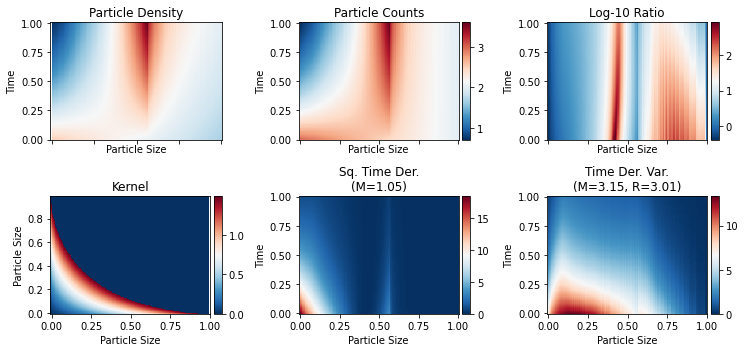

In [11]:
# Plotting the true solution (Euler integration through time)
fig = plot_true_solution()

### High Variance Attempt
This attempt trains a network with the full gradients and a 1 points per interval.

In [12]:
n_i = 400
n_j = 1
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 1.0
w_tot = 1.0
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/01_hvmse_{timestamp}'
fig = train()

Epoch 0, loss = 3.5024 +/- 0.0000, loss_sm = 0.0345 +/- 0.0000, loss_ic = 3.4679 +/- 0.0000
Epoch 1000, loss = 2.0442 +/- 0.0000, loss_sm = 0.3761 +/- 0.0172, loss_ic = 1.6681 +/- 0.0000
Epoch 2000, loss = 1.4497 +/- 0.0000, loss_sm = 0.4954 +/- 0.0123, loss_ic = 0.9543 +/- 0.0000
Epoch 3000, loss = 1.2283 +/- 0.0000, loss_sm = 0.5384 +/- 0.0082, loss_ic = 0.6899 +/- 0.0000
Epoch 4000, loss = 1.1445 +/- 0.0000, loss_sm = 0.5542 +/- 0.0056, loss_ic = 0.5902 +/- 0.0000
Epoch 5000, loss = 1.1116 +/- 0.0000, loss_sm = 0.5587 +/- 0.0042, loss_ic = 0.5529 +/- 0.0000
Epoch 6000, loss = 1.1006 +/- 0.0000, loss_sm = 0.5603 +/- 0.0037, loss_ic = 0.5403 +/- 0.0000
Epoch 7000, loss = 1.0929 +/- 0.0000, loss_sm = 0.5598 +/- 0.0034, loss_ic = 0.5331 +/- 0.0000
Epoch 8000, loss = 1.0905 +/- 0.0026, loss_sm = 0.5600 +/- 0.0031, loss_ic = 0.5304 +/- 0.0016
Epoch 9000, loss = 1.0905 +/- 0.0033, loss_sm = 0.5607 +/- 0.0032, loss_ic = 0.5298 +/- 0.0020
Epoch 10000, loss = 1.0907 +/- 0.0037, loss_sm = 0.56

Epoch 86000, loss = 1.0843 +/- 0.0034, loss_sm = 0.5572 +/- 0.0030, loss_ic = 0.5271 +/- 0.0017
Epoch 87000, loss = 1.0847 +/- 0.0033, loss_sm = 0.5584 +/- 0.0030, loss_ic = 0.5263 +/- 0.0012
Epoch 88000, loss = 1.0866 +/- 0.0043, loss_sm = 0.5582 +/- 0.0032, loss_ic = 0.5284 +/- 0.0023
Epoch 89000, loss = 1.0864 +/- 0.0036, loss_sm = 0.5580 +/- 0.0030, loss_ic = 0.5284 +/- 0.0018
Epoch 90000, loss = 1.0808 +/- 0.0008, loss_sm = 0.5568 +/- 0.0028, loss_ic = 0.5240 +/- 0.0000
Epoch 91000, loss = 1.0843 +/- 0.0047, loss_sm = 0.5573 +/- 0.0031, loss_ic = 0.5269 +/- 0.0026
Epoch 92000, loss = 1.0850 +/- 0.0040, loss_sm = 0.5578 +/- 0.0032, loss_ic = 0.5271 +/- 0.0019
Epoch 93000, loss = 1.0811 +/- 0.0024, loss_sm = 0.5564 +/- 0.0028, loss_ic = 0.5247 +/- 0.0009
Epoch 94000, loss = 1.0823 +/- 0.0034, loss_sm = 0.5549 +/- 0.0026, loss_ic = 0.5275 +/- 0.0021
Epoch 95000, loss = 1.0847 +/- 0.0044, loss_sm = 0.5580 +/- 0.0036, loss_ic = 0.5267 +/- 0.0018
Epoch 96000, loss = 1.0861 +/- 0.0037, l

Epoch 171000, loss = 1.0861 +/- 0.0042, loss_sm = 0.5591 +/- 0.0033, loss_ic = 0.5270 +/- 0.0020
Epoch 172000, loss = 1.0844 +/- 0.0035, loss_sm = 0.5576 +/- 0.0029, loss_ic = 0.5268 +/- 0.0017
Epoch 173000, loss = 1.0842 +/- 0.0042, loss_sm = 0.5577 +/- 0.0031, loss_ic = 0.5265 +/- 0.0021
Epoch 174000, loss = 1.0863 +/- 0.0048, loss_sm = 0.5584 +/- 0.0033, loss_ic = 0.5279 +/- 0.0024
Epoch 175000, loss = 1.0851 +/- 0.0042, loss_sm = 0.5586 +/- 0.0033, loss_ic = 0.5265 +/- 0.0018
Epoch 176000, loss = 1.0848 +/- 0.0033, loss_sm = 0.5582 +/- 0.0031, loss_ic = 0.5266 +/- 0.0013
Epoch 177000, loss = 1.0860 +/- 0.0037, loss_sm = 0.5587 +/- 0.0029, loss_ic = 0.5273 +/- 0.0019
Epoch 178000, loss = 1.0838 +/- 0.0032, loss_sm = 0.5570 +/- 0.0027, loss_ic = 0.5268 +/- 0.0019
Epoch 179000, loss = 1.0861 +/- 0.0041, loss_sm = 0.5590 +/- 0.0033, loss_ic = 0.5271 +/- 0.0018
Epoch 180000, loss = 1.0821 +/- 0.0032, loss_sm = 0.5566 +/- 0.0028, loss_ic = 0.5255 +/- 0.0017
Epoch 181000, loss = 1.0845 +/

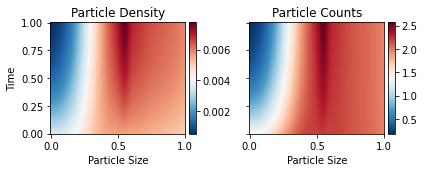

In [13]:
fig

### Low Variance Attempt
This attempt trains a network with the full gradients and a 100 points per interval.

In [14]:
n_i = 4
n_j = 100
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 1.0
w_tot = 1.0
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/02_lvmse_{timestamp}'
fig = train()

Epoch 0, loss = 3.4763 +/- 0.0000, loss_sm = 0.0048 +/- 0.0000, loss_ic = 3.4715 +/- 0.0000, integ_var = 0.0277 +/- 0.0000
Epoch 1000, loss = 1.4846 +/- 0.0000, loss_sm = 0.1325 +/- 0.0094, loss_ic = 1.3521 +/- 0.0000, integ_var = 1.4235 +/- 0.0870
Epoch 2000, loss = 0.6110 +/- 0.0000, loss_sm = 0.1057 +/- 0.0049, loss_ic = 0.5053 +/- 0.0000, integ_var = 2.2310 +/- 0.0841
Epoch 3000, loss = 0.2797 +/- 0.0000, loss_sm = 0.0873 +/- 0.0033, loss_ic = 0.1924 +/- 0.0000, integ_var = 2.6143 +/- 0.0735
Epoch 4000, loss = 0.1530 +/- 0.0000, loss_sm = 0.0768 +/- 0.0030, loss_ic = 0.0762 +/- 0.0000, integ_var = 2.7570 +/- 0.0664
Epoch 5000, loss = 0.1023 +/- 0.0000, loss_sm = 0.0696 +/- 0.0027, loss_ic = 0.0327 +/- 0.0000, integ_var = 2.7602 +/- 0.0577
Epoch 6000, loss = 0.0809 +/- 0.0021, loss_sm = 0.0645 +/- 0.0027, loss_ic = 0.0164 +/- 0.0000, integ_var = 2.7351 +/- 0.0563
Epoch 7000, loss = 0.0712 +/- 0.0025, loss_sm = 0.0615 +/- 0.0027, loss_ic = 0.0096 +/- 0.0001, integ_var = 2.8202 +/- 0.

Epoch 65000, loss = 0.0358 +/- 0.0016, loss_sm = 0.0343 +/- 0.0016, loss_ic = 0.0015 +/- 0.0001, integ_var = 2.9957 +/- 0.0633
Epoch 66000, loss = 0.0370 +/- 0.0017, loss_sm = 0.0355 +/- 0.0017, loss_ic = 0.0015 +/- 0.0001, integ_var = 3.0080 +/- 0.0581
Epoch 67000, loss = 0.0370 +/- 0.0015, loss_sm = 0.0355 +/- 0.0015, loss_ic = 0.0015 +/- 0.0001, integ_var = 3.0530 +/- 0.0622
Epoch 68000, loss = 0.0359 +/- 0.0016, loss_sm = 0.0344 +/- 0.0016, loss_ic = 0.0015 +/- 0.0001, integ_var = 3.0121 +/- 0.0588
Epoch 69000, loss = 0.0382 +/- 0.0018, loss_sm = 0.0367 +/- 0.0017, loss_ic = 0.0015 +/- 0.0001, integ_var = 3.0249 +/- 0.0584
Epoch 70000, loss = 0.0362 +/- 0.0015, loss_sm = 0.0348 +/- 0.0015, loss_ic = 0.0014 +/- 0.0001, integ_var = 3.0355 +/- 0.0621
Epoch 71000, loss = 0.0378 +/- 0.0018, loss_sm = 0.0362 +/- 0.0018, loss_ic = 0.0016 +/- 0.0001, integ_var = 2.9671 +/- 0.0592
Epoch 72000, loss = 0.0363 +/- 0.0016, loss_sm = 0.0348 +/- 0.0016, loss_ic = 0.0015 +/- 0.0001, integ_var = 2.

Epoch 130000, loss = 0.0348 +/- 0.0015, loss_sm = 0.0337 +/- 0.0015, loss_ic = 0.0011 +/- 0.0000, integ_var = 3.0343 +/- 0.0589
Epoch 131000, loss = 0.0342 +/- 0.0016, loss_sm = 0.0331 +/- 0.0016, loss_ic = 0.0012 +/- 0.0001, integ_var = 2.9932 +/- 0.0573
Epoch 132000, loss = 0.0339 +/- 0.0014, loss_sm = 0.0327 +/- 0.0014, loss_ic = 0.0012 +/- 0.0001, integ_var = 3.0212 +/- 0.0620
Epoch 133000, loss = 0.0347 +/- 0.0015, loss_sm = 0.0335 +/- 0.0015, loss_ic = 0.0012 +/- 0.0001, integ_var = 2.9563 +/- 0.0571
Epoch 134000, loss = 0.0351 +/- 0.0016, loss_sm = 0.0338 +/- 0.0016, loss_ic = 0.0012 +/- 0.0001, integ_var = 2.9849 +/- 0.0583
Epoch 135000, loss = 0.0356 +/- 0.0016, loss_sm = 0.0344 +/- 0.0016, loss_ic = 0.0012 +/- 0.0001, integ_var = 3.0036 +/- 0.0592
Epoch 136000, loss = 0.0350 +/- 0.0014, loss_sm = 0.0338 +/- 0.0014, loss_ic = 0.0011 +/- 0.0001, integ_var = 2.9579 +/- 0.0552
Epoch 137000, loss = 0.0349 +/- 0.0015, loss_sm = 0.0338 +/- 0.0015, loss_ic = 0.0012 +/- 0.0001, integ_

Epoch 195000, loss = 0.0360 +/- 0.0016, loss_sm = 0.0347 +/- 0.0016, loss_ic = 0.0013 +/- 0.0001, integ_var = 3.0042 +/- 0.0589
Epoch 196000, loss = 0.0351 +/- 0.0015, loss_sm = 0.0340 +/- 0.0015, loss_ic = 0.0012 +/- 0.0001, integ_var = 2.9520 +/- 0.0557
Epoch 197000, loss = 0.0348 +/- 0.0016, loss_sm = 0.0337 +/- 0.0016, loss_ic = 0.0011 +/- 0.0001, integ_var = 2.9445 +/- 0.0570
Epoch 198000, loss = 0.0325 +/- 0.0014, loss_sm = 0.0315 +/- 0.0014, loss_ic = 0.0010 +/- 0.0000, integ_var = 2.9185 +/- 0.0567
Epoch 199000, loss = 0.0323 +/- 0.0013, loss_sm = 0.0313 +/- 0.0013, loss_ic = 0.0010 +/- 0.0000, integ_var = 2.9487 +/- 0.0602


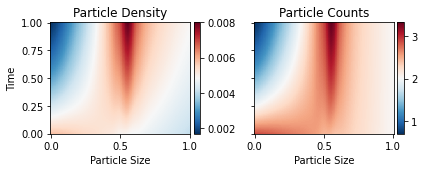

In [15]:
fig

### High Variance Attempt (Higher IC Weight)
This attempt trains a network with the full gradients and a 1 points per interval.

In [16]:
n_i = 400
n_j = 1
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 10.0
w_tot = 0.1
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/03_hvmse_{timestamp}'
fig = train()

Epoch 0, loss = 3.4714 +/- 0.0000, loss_sm = 0.0034 +/- 0.0000, loss_ic = 3.4679 +/- 0.0000
Epoch 1000, loss = 1.4599 +/- 0.0000, loss_sm = 0.1362 +/- 0.0063, loss_ic = 1.3237 +/- 0.0000
Epoch 2000, loss = 0.6666 +/- 0.0000, loss_sm = 0.1659 +/- 0.0038, loss_ic = 0.5007 +/- 0.0000
Epoch 3000, loss = 0.3743 +/- 0.0000, loss_sm = 0.1760 +/- 0.0024, loss_ic = 0.1982 +/- 0.0000
Epoch 4000, loss = 0.2659 +/- 0.0000, loss_sm = 0.1793 +/- 0.0016, loss_ic = 0.0866 +/- 0.0000
Epoch 5000, loss = 0.2259 +/- 0.0000, loss_sm = 0.1804 +/- 0.0013, loss_ic = 0.0455 +/- 0.0000
Epoch 6000, loss = 0.2117 +/- 0.0000, loss_sm = 0.1812 +/- 0.0012, loss_ic = 0.0306 +/- 0.0000
Epoch 7000, loss = 0.2055 +/- 0.0000, loss_sm = 0.1806 +/- 0.0009, loss_ic = 0.0249 +/- 0.0000
Epoch 8000, loss = 0.2034 +/- 0.0002, loss_sm = 0.1806 +/- 0.0010, loss_ic = 0.0227 +/- 0.0000
Epoch 9000, loss = 0.2025 +/- 0.0007, loss_sm = 0.1806 +/- 0.0010, loss_ic = 0.0219 +/- 0.0001
Epoch 10000, loss = 0.2027 +/- 0.0010, loss_sm = 0.18

Epoch 86000, loss = 0.2010 +/- 0.0009, loss_sm = 0.1799 +/- 0.0009, loss_ic = 0.0211 +/- 0.0001
Epoch 87000, loss = 0.2008 +/- 0.0008, loss_sm = 0.1798 +/- 0.0009, loss_ic = 0.0210 +/- 0.0001
Epoch 88000, loss = 0.2017 +/- 0.0012, loss_sm = 0.1805 +/- 0.0011, loss_ic = 0.0212 +/- 0.0002
Epoch 89000, loss = 0.2015 +/- 0.0010, loss_sm = 0.1804 +/- 0.0010, loss_ic = 0.0212 +/- 0.0001
Epoch 90000, loss = 0.1999 +/- 0.0005, loss_sm = 0.1791 +/- 0.0007, loss_ic = 0.0209 +/- 0.0001
Epoch 91000, loss = 0.2011 +/- 0.0012, loss_sm = 0.1800 +/- 0.0011, loss_ic = 0.0211 +/- 0.0002
Epoch 92000, loss = 0.2011 +/- 0.0010, loss_sm = 0.1800 +/- 0.0010, loss_ic = 0.0211 +/- 0.0002
Epoch 93000, loss = 0.2001 +/- 0.0008, loss_sm = 0.1792 +/- 0.0008, loss_ic = 0.0209 +/- 0.0001
Epoch 94000, loss = 0.2010 +/- 0.0010, loss_sm = 0.1798 +/- 0.0010, loss_ic = 0.0211 +/- 0.0002
Epoch 95000, loss = 0.2008 +/- 0.0010, loss_sm = 0.1798 +/- 0.0010, loss_ic = 0.0210 +/- 0.0001
Epoch 96000, loss = 0.2014 +/- 0.0010, l

Epoch 171000, loss = 0.2011 +/- 0.0011, loss_sm = 0.1801 +/- 0.0011, loss_ic = 0.0209 +/- 0.0001
Epoch 172000, loss = 0.2008 +/- 0.0010, loss_sm = 0.1799 +/- 0.0010, loss_ic = 0.0209 +/- 0.0001
Epoch 173000, loss = 0.2008 +/- 0.0011, loss_sm = 0.1798 +/- 0.0010, loss_ic = 0.0209 +/- 0.0001
Epoch 174000, loss = 0.2012 +/- 0.0011, loss_sm = 0.1802 +/- 0.0011, loss_ic = 0.0210 +/- 0.0001
Epoch 175000, loss = 0.2009 +/- 0.0010, loss_sm = 0.1799 +/- 0.0010, loss_ic = 0.0209 +/- 0.0001
Epoch 176000, loss = 0.2008 +/- 0.0009, loss_sm = 0.1799 +/- 0.0009, loss_ic = 0.0209 +/- 0.0001
Epoch 177000, loss = 0.2010 +/- 0.0010, loss_sm = 0.1800 +/- 0.0010, loss_ic = 0.0210 +/- 0.0001
Epoch 178000, loss = 0.2007 +/- 0.0009, loss_sm = 0.1797 +/- 0.0009, loss_ic = 0.0209 +/- 0.0001
Epoch 179000, loss = 0.2010 +/- 0.0010, loss_sm = 0.1801 +/- 0.0010, loss_ic = 0.0210 +/- 0.0001
Epoch 180000, loss = 0.2003 +/- 0.0009, loss_sm = 0.1794 +/- 0.0009, loss_ic = 0.0209 +/- 0.0001
Epoch 181000, loss = 0.2008 +/

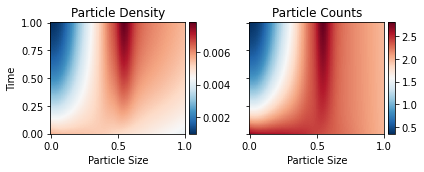

In [17]:
fig

### Low Variance Attempt  (Higher IC Weight)
This attempt trains a network with the full gradients and a 100 points per interval.

In [18]:
n_i = 4
n_j = 100
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 10.0
w_tot = 0.1
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/04_lvmse_{timestamp}'
fig = train()

Epoch 0, loss = 3.4720 +/- 0.0000, loss_sm = 0.0005 +/- 0.0000, loss_ic = 3.4715 +/- 0.0000, integ_var = 0.0277 +/- 0.0000
Epoch 1000, loss = 1.3414 +/- 0.0000, loss_sm = 0.0342 +/- 0.0023, loss_ic = 1.3072 +/- 0.0000, integ_var = 1.9227 +/- 0.1070
Epoch 2000, loss = 0.5019 +/- 0.0000, loss_sm = 0.0207 +/- 0.0009, loss_ic = 0.4811 +/- 0.0000, integ_var = 2.5882 +/- 0.0881
Epoch 3000, loss = 0.1912 +/- 0.0000, loss_sm = 0.0139 +/- 0.0004, loss_ic = 0.1774 +/- 0.0000, integ_var = 2.8975 +/- 0.0759
Epoch 4000, loss = 0.0759 +/- 0.0000, loss_sm = 0.0101 +/- 0.0003, loss_ic = 0.0657 +/- 0.0000, integ_var = 3.0065 +/- 0.0692
Epoch 5000, loss = 0.0330 +/- 0.0000, loss_sm = 0.0082 +/- 0.0003, loss_ic = 0.0247 +/- 0.0000, integ_var = 2.9814 +/- 0.0605
Epoch 6000, loss = 0.0166 +/- 0.0000, loss_sm = 0.0072 +/- 0.0003, loss_ic = 0.0094 +/- 0.0000, integ_var = 2.9341 +/- 0.0598
Epoch 7000, loss = 0.0106 +/- 0.0000, loss_sm = 0.0068 +/- 0.0003, loss_ic = 0.0038 +/- 0.0000, integ_var = 3.0085 +/- 0.

Epoch 65000, loss = 0.0037 +/- 0.0002, loss_sm = 0.0036 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1073 +/- 0.0656
Epoch 66000, loss = 0.0039 +/- 0.0002, loss_sm = 0.0037 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1211 +/- 0.0605
Epoch 67000, loss = 0.0039 +/- 0.0002, loss_sm = 0.0037 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1695 +/- 0.0649
Epoch 68000, loss = 0.0038 +/- 0.0002, loss_sm = 0.0036 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1304 +/- 0.0614
Epoch 69000, loss = 0.0040 +/- 0.0002, loss_sm = 0.0039 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1473 +/- 0.0613
Epoch 70000, loss = 0.0038 +/- 0.0002, loss_sm = 0.0037 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1526 +/- 0.0647
Epoch 71000, loss = 0.0040 +/- 0.0002, loss_sm = 0.0038 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.0888 +/- 0.0626
Epoch 72000, loss = 0.0038 +/- 0.0002, loss_sm = 0.0037 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.

Epoch 130000, loss = 0.0036 +/- 0.0002, loss_sm = 0.0035 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1518 +/- 0.0617
Epoch 131000, loss = 0.0035 +/- 0.0002, loss_sm = 0.0034 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1065 +/- 0.0601
Epoch 132000, loss = 0.0035 +/- 0.0002, loss_sm = 0.0034 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1325 +/- 0.0640
Epoch 133000, loss = 0.0036 +/- 0.0002, loss_sm = 0.0035 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.0653 +/- 0.0591
Epoch 134000, loss = 0.0036 +/- 0.0002, loss_sm = 0.0035 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.0951 +/- 0.0607
Epoch 135000, loss = 0.0037 +/- 0.0002, loss_sm = 0.0036 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1170 +/- 0.0621
Epoch 136000, loss = 0.0036 +/- 0.0001, loss_sm = 0.0035 +/- 0.0001, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.0664 +/- 0.0572
Epoch 137000, loss = 0.0036 +/- 0.0002, loss_sm = 0.0035 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_

Epoch 195000, loss = 0.0037 +/- 0.0002, loss_sm = 0.0036 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.1196 +/- 0.0613
Epoch 196000, loss = 0.0036 +/- 0.0002, loss_sm = 0.0035 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.0615 +/- 0.0574
Epoch 197000, loss = 0.0036 +/- 0.0002, loss_sm = 0.0035 +/- 0.0002, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.0562 +/- 0.0594
Epoch 198000, loss = 0.0033 +/- 0.0001, loss_sm = 0.0033 +/- 0.0001, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.0211 +/- 0.0581
Epoch 199000, loss = 0.0033 +/- 0.0001, loss_sm = 0.0032 +/- 0.0001, loss_ic = 0.0001 +/- 0.0000, integ_var = 3.0538 +/- 0.0625


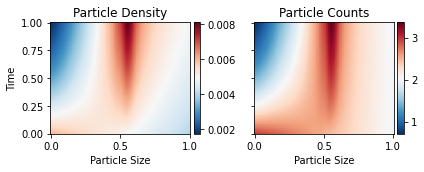

In [19]:
fig

# Second Problem

In [20]:
"""
The following was tested to produce issues for high-variance trainings.
We used w_tot, w_ic = 1.0, 1.0 was used in this trainings.
This setting has a low "variance to squared-mean" ratio for the time derivative:
   E_{xi}[Var_{xj}(d\rho/dt)] = 4.39
   E_{xi}[  E_{xj}[d\rho/dt]] = 201.59
   R = 4.39 / 201.59 = 0.02
That being said, since the initial condition loss has a low weight, the 
time-derivative variance prohibited the model from settling on the right 
initial condition. This resulted in a training with a wrong heatmap trend.
"""

d = 1
n_gpd = 100
x_high = torch.tensor([0.3]*d, dtype=tch_dtype, device=tch_device)
get_kernel = CustomKernel(pnorm=1.0, maxnorm=1.0, scale=5.5, 
    alpha=-1.0, beta=-1.0, gamma=0.15)
get_rhoinit = RhoGMM(pi=[1.0], mu=[0.0], std=[0.4], bias=1.5, scale=2.0)
t_high = 0.03
dt_g = t_high / 100.0
ker_name, rhoi_name = 'harmonic_B', 'gmm_B'

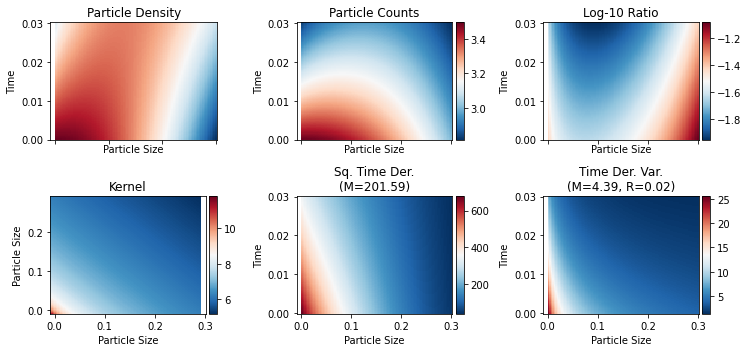

In [21]:
# Plotting the true solution (Euler integration through time)
fig = plot_true_solution()

### High Variance Attempt
This attempt trains a network with the full gradients and a 1 points per interval.

In [22]:
n_i = 400
n_j = 1
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 1.0
w_tot = 1.0
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/05_hvmse_{timestamp}'
fig = train()

Epoch 0, loss = 7.5174 +/- 0.0000, loss_sm = 0.4068 +/- 0.0000, loss_ic = 7.1105 +/- 0.0000
Epoch 1000, loss = 3.6319 +/- 0.0000, loss_sm = 0.5691 +/- 0.0117, loss_ic = 3.0628 +/- 0.0000
Epoch 2000, loss = 1.7807 +/- 0.0000, loss_sm = 0.4723 +/- 0.0000, loss_ic = 1.3084 +/- 0.0000
Epoch 3000, loss = 0.9002 +/- 0.0000, loss_sm = 0.3267 +/- 0.0000, loss_ic = 0.5735 +/- 0.0000
Epoch 4000, loss = 0.5539 +/- 0.0000, loss_sm = 0.2615 +/- 0.0000, loss_ic = 0.2924 +/- 0.0000
Epoch 5000, loss = 0.4213 +/- 0.0000, loss_sm = 0.2339 +/- 0.0000, loss_ic = 0.1874 +/- 0.0000
Epoch 6000, loss = 0.3743 +/- 0.0000, loss_sm = 0.2250 +/- 0.0030, loss_ic = 0.1492 +/- 0.0000
Epoch 7000, loss = 0.3537 +/- 0.0018, loss_sm = 0.2196 +/- 0.0039, loss_ic = 0.1341 +/- 0.0000
Epoch 8000, loss = 0.3502 +/- 0.0038, loss_sm = 0.2209 +/- 0.0043, loss_ic = 0.1293 +/- 0.0000
Epoch 9000, loss = 0.3451 +/- 0.0034, loss_sm = 0.2184 +/- 0.0038, loss_ic = 0.1267 +/- 0.0000
Epoch 10000, loss = 0.3414 +/- 0.0033, loss_sm = 0.21

Epoch 86000, loss = 0.3302 +/- 0.0033, loss_sm = 0.2078 +/- 0.0032, loss_ic = 0.1224 +/- 0.0005
Epoch 87000, loss = 0.3333 +/- 0.0042, loss_sm = 0.2102 +/- 0.0041, loss_ic = 0.1231 +/- 0.0006
Epoch 88000, loss = 0.3341 +/- 0.0038, loss_sm = 0.2109 +/- 0.0037, loss_ic = 0.1232 +/- 0.0005
Epoch 89000, loss = 0.3335 +/- 0.0034, loss_sm = 0.2104 +/- 0.0034, loss_ic = 0.1231 +/- 0.0005
Epoch 90000, loss = 0.3287 +/- 0.0023, loss_sm = 0.2067 +/- 0.0027, loss_ic = 0.1220 +/- 0.0000
Epoch 91000, loss = 0.3294 +/- 0.0035, loss_sm = 0.2072 +/- 0.0034, loss_ic = 0.1222 +/- 0.0005
Epoch 92000, loss = 0.3327 +/- 0.0037, loss_sm = 0.2099 +/- 0.0035, loss_ic = 0.1228 +/- 0.0006
Epoch 93000, loss = 0.3357 +/- 0.0040, loss_sm = 0.2126 +/- 0.0039, loss_ic = 0.1232 +/- 0.0005
Epoch 94000, loss = 0.3289 +/- 0.0027, loss_sm = 0.2069 +/- 0.0029, loss_ic = 0.1220 +/- 0.0000
Epoch 95000, loss = 0.3308 +/- 0.0036, loss_sm = 0.2083 +/- 0.0034, loss_ic = 0.1226 +/- 0.0006
Epoch 96000, loss = 0.3284 +/- 0.0030, l

Epoch 171000, loss = 0.3309 +/- 0.0034, loss_sm = 0.2087 +/- 0.0034, loss_ic = 0.1223 +/- 0.0002
Epoch 172000, loss = 0.3335 +/- 0.0040, loss_sm = 0.2107 +/- 0.0039, loss_ic = 0.1228 +/- 0.0005
Epoch 173000, loss = 0.3332 +/- 0.0034, loss_sm = 0.2106 +/- 0.0033, loss_ic = 0.1226 +/- 0.0004
Epoch 174000, loss = 0.3324 +/- 0.0035, loss_sm = 0.2097 +/- 0.0035, loss_ic = 0.1227 +/- 0.0005
Epoch 175000, loss = 0.3284 +/- 0.0029, loss_sm = 0.2066 +/- 0.0030, loss_ic = 0.1218 +/- 0.0000
Epoch 176000, loss = 0.3320 +/- 0.0044, loss_sm = 0.2092 +/- 0.0042, loss_ic = 0.1228 +/- 0.0007
Epoch 177000, loss = 0.3331 +/- 0.0037, loss_sm = 0.2100 +/- 0.0036, loss_ic = 0.1231 +/- 0.0005
Epoch 178000, loss = 0.3318 +/- 0.0035, loss_sm = 0.2093 +/- 0.0034, loss_ic = 0.1225 +/- 0.0004
Epoch 179000, loss = 0.3314 +/- 0.0033, loss_sm = 0.2089 +/- 0.0033, loss_ic = 0.1225 +/- 0.0003
Epoch 180000, loss = 0.3304 +/- 0.0036, loss_sm = 0.2084 +/- 0.0035, loss_ic = 0.1220 +/- 0.0004
Epoch 181000, loss = 0.3298 +/

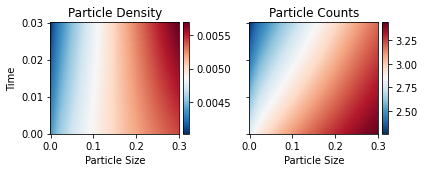

In [23]:
fig

### Low Variance Attempt
This attempt trains a network with the full gradients and a 100 points per interval.

In [24]:
n_i = 4
n_j = 100
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 1.0
w_tot = 1.0
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/06_lvmse_{timestamp}'
fig = train()

Epoch 0, loss = 7.5614 +/- 0.0000, loss_sm = 0.3928 +/- 0.0000, loss_ic = 7.1687 +/- 0.0000, integ_var = 0.0035 +/- 0.0000
Epoch 1000, loss = 3.8133 +/- 0.0000, loss_sm = 0.5128 +/- 0.0195, loss_ic = 3.3005 +/- 0.0000, integ_var = 1.3840 +/- 0.0756
Epoch 2000, loss = 2.1818 +/- 0.0000, loss_sm = 0.5535 +/- 0.0206, loss_ic = 1.6282 +/- 0.0000, integ_var = 0.9991 +/- 0.0196
Epoch 3000, loss = 1.4040 +/- 0.0000, loss_sm = 0.5362 +/- 0.0173, loss_ic = 0.8679 +/- 0.0000, integ_var = 0.5312 +/- 0.0000
Epoch 4000, loss = 0.8962 +/- 0.0000, loss_sm = 0.4382 +/- 0.0145, loss_ic = 0.4580 +/- 0.0000, integ_var = 0.7354 +/- 0.0318
Epoch 5000, loss = 0.5151 +/- 0.0000, loss_sm = 0.2935 +/- 0.0079, loss_ic = 0.2216 +/- 0.0000, integ_var = 1.0754 +/- 0.0428
Epoch 6000, loss = 0.2966 +/- 0.0000, loss_sm = 0.1889 +/- 0.0053, loss_ic = 0.1077 +/- 0.0000, integ_var = 1.2970 +/- 0.0480
Epoch 7000, loss = 0.2001 +/- 0.0028, loss_sm = 0.1399 +/- 0.0050, loss_ic = 0.0601 +/- 0.0000, integ_var = 1.3477 +/- 0.

Epoch 65000, loss = 0.0494 +/- 0.0021, loss_sm = 0.0404 +/- 0.0020, loss_ic = 0.0090 +/- 0.0003, integ_var = 2.2504 +/- 0.0552
Epoch 66000, loss = 0.0480 +/- 0.0017, loss_sm = 0.0392 +/- 0.0017, loss_ic = 0.0088 +/- 0.0002, integ_var = 2.2311 +/- 0.0502
Epoch 67000, loss = 0.0481 +/- 0.0016, loss_sm = 0.0394 +/- 0.0015, loss_ic = 0.0087 +/- 0.0003, integ_var = 2.2844 +/- 0.0548
Epoch 68000, loss = 0.0466 +/- 0.0021, loss_sm = 0.0378 +/- 0.0020, loss_ic = 0.0088 +/- 0.0003, integ_var = 2.2743 +/- 0.0517
Epoch 69000, loss = 0.0485 +/- 0.0020, loss_sm = 0.0394 +/- 0.0019, loss_ic = 0.0091 +/- 0.0003, integ_var = 2.2682 +/- 0.0528
Epoch 70000, loss = 0.0460 +/- 0.0018, loss_sm = 0.0374 +/- 0.0018, loss_ic = 0.0086 +/- 0.0002, integ_var = 2.2761 +/- 0.0516
Epoch 71000, loss = 0.0486 +/- 0.0023, loss_sm = 0.0398 +/- 0.0022, loss_ic = 0.0089 +/- 0.0003, integ_var = 2.2267 +/- 0.0502
Epoch 72000, loss = 0.0479 +/- 0.0021, loss_sm = 0.0388 +/- 0.0020, loss_ic = 0.0091 +/- 0.0003, integ_var = 2.

Epoch 130000, loss = 0.0433 +/- 0.0017, loss_sm = 0.0353 +/- 0.0016, loss_ic = 0.0080 +/- 0.0002, integ_var = 2.2968 +/- 0.0492
Epoch 131000, loss = 0.0453 +/- 0.0018, loss_sm = 0.0369 +/- 0.0018, loss_ic = 0.0083 +/- 0.0003, integ_var = 2.2865 +/- 0.0514
Epoch 132000, loss = 0.0440 +/- 0.0017, loss_sm = 0.0358 +/- 0.0016, loss_ic = 0.0083 +/- 0.0002, integ_var = 2.2828 +/- 0.0539
Epoch 133000, loss = 0.0444 +/- 0.0019, loss_sm = 0.0358 +/- 0.0017, loss_ic = 0.0086 +/- 0.0004, integ_var = 2.2456 +/- 0.0463
Epoch 134000, loss = 0.0439 +/- 0.0016, loss_sm = 0.0354 +/- 0.0015, loss_ic = 0.0086 +/- 0.0003, integ_var = 2.2558 +/- 0.0482
Epoch 135000, loss = 0.0443 +/- 0.0017, loss_sm = 0.0357 +/- 0.0016, loss_ic = 0.0086 +/- 0.0003, integ_var = 2.2355 +/- 0.0507
Epoch 136000, loss = 0.0442 +/- 0.0018, loss_sm = 0.0360 +/- 0.0017, loss_ic = 0.0082 +/- 0.0002, integ_var = 2.2412 +/- 0.0512
Epoch 137000, loss = 0.0454 +/- 0.0019, loss_sm = 0.0367 +/- 0.0018, loss_ic = 0.0087 +/- 0.0003, integ_

Epoch 197000, loss = 0.0430 +/- 0.0017, loss_sm = 0.0350 +/- 0.0016, loss_ic = 0.0080 +/- 0.0002, integ_var = 2.2319 +/- 0.0504
Epoch 198000, loss = 0.0419 +/- 0.0016, loss_sm = 0.0340 +/- 0.0015, loss_ic = 0.0079 +/- 0.0002, integ_var = 2.2419 +/- 0.0514
Epoch 199000, loss = 0.0428 +/- 0.0017, loss_sm = 0.0350 +/- 0.0016, loss_ic = 0.0078 +/- 0.0002, integ_var = 2.2493 +/- 0.0505


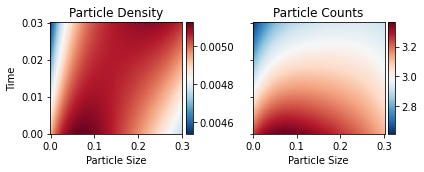

In [25]:
fig

### High Variance Attempt (Higher IC Weight)
This attempt trains a network with the full gradients and a 1 points per interval.

In [26]:
n_i = 400
n_j = 1
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 10.0
w_tot = 0.1
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/07_hvmse_{timestamp}'
fig = train()

Epoch 0, loss = 7.1512 +/- 0.0000, loss_sm = 0.0407 +/- 0.0000, loss_ic = 7.1105 +/- 0.0000
Epoch 1000, loss = 2.9802 +/- 0.0000, loss_sm = 0.1707 +/- 0.0088, loss_ic = 2.8096 +/- 0.0000
Epoch 2000, loss = 1.2237 +/- 0.0000, loss_sm = 0.1396 +/- 0.0021, loss_ic = 1.0841 +/- 0.0000
Epoch 3000, loss = 0.5416 +/- 0.0000, loss_sm = 0.0986 +/- 0.0000, loss_ic = 0.4430 +/- 0.0000
Epoch 4000, loss = 0.2749 +/- 0.0000, loss_sm = 0.0696 +/- 0.0000, loss_ic = 0.2054 +/- 0.0000
Epoch 5000, loss = 0.1740 +/- 0.0000, loss_sm = 0.0563 +/- 0.0000, loss_ic = 0.1177 +/- 0.0000
Epoch 6000, loss = 0.1369 +/- 0.0000, loss_sm = 0.0513 +/- 0.0000, loss_ic = 0.0857 +/- 0.0000
Epoch 7000, loss = 0.1221 +/- 0.0000, loss_sm = 0.0485 +/- 0.0004, loss_ic = 0.0736 +/- 0.0000
Epoch 8000, loss = 0.1168 +/- 0.0000, loss_sm = 0.0474 +/- 0.0006, loss_ic = 0.0693 +/- 0.0000
Epoch 9000, loss = 0.1140 +/- 0.0000, loss_sm = 0.0464 +/- 0.0005, loss_ic = 0.0676 +/- 0.0000
Epoch 10000, loss = 0.1125 +/- 0.0001, loss_sm = 0.04

Epoch 86000, loss = 0.1089 +/- 0.0005, loss_sm = 0.0440 +/- 0.0005, loss_ic = 0.0650 +/- 0.0002
Epoch 87000, loss = 0.1095 +/- 0.0007, loss_sm = 0.0444 +/- 0.0006, loss_ic = 0.0650 +/- 0.0002
Epoch 88000, loss = 0.1096 +/- 0.0006, loss_sm = 0.0445 +/- 0.0006, loss_ic = 0.0651 +/- 0.0002
Epoch 89000, loss = 0.1096 +/- 0.0006, loss_sm = 0.0444 +/- 0.0005, loss_ic = 0.0651 +/- 0.0002
Epoch 90000, loss = 0.1087 +/- 0.0002, loss_sm = 0.0439 +/- 0.0004, loss_ic = 0.0648 +/- 0.0000
Epoch 91000, loss = 0.1088 +/- 0.0006, loss_sm = 0.0440 +/- 0.0005, loss_ic = 0.0649 +/- 0.0002
Epoch 92000, loss = 0.1093 +/- 0.0006, loss_sm = 0.0443 +/- 0.0005, loss_ic = 0.0650 +/- 0.0002
Epoch 93000, loss = 0.1096 +/- 0.0006, loss_sm = 0.0445 +/- 0.0006, loss_ic = 0.0650 +/- 0.0001
Epoch 94000, loss = 0.1088 +/- 0.0004, loss_sm = 0.0439 +/- 0.0005, loss_ic = 0.0648 +/- 0.0001
Epoch 95000, loss = 0.1092 +/- 0.0006, loss_sm = 0.0442 +/- 0.0005, loss_ic = 0.0650 +/- 0.0002
Epoch 96000, loss = 0.1086 +/- 0.0004, l

Epoch 171000, loss = 0.1090 +/- 0.0005, loss_sm = 0.0441 +/- 0.0005, loss_ic = 0.0649 +/- 0.0001
Epoch 172000, loss = 0.1093 +/- 0.0007, loss_sm = 0.0443 +/- 0.0006, loss_ic = 0.0650 +/- 0.0002
Epoch 173000, loss = 0.1092 +/- 0.0006, loss_sm = 0.0443 +/- 0.0005, loss_ic = 0.0649 +/- 0.0002
Epoch 174000, loss = 0.1093 +/- 0.0006, loss_sm = 0.0443 +/- 0.0005, loss_ic = 0.0650 +/- 0.0002
Epoch 175000, loss = 0.1086 +/- 0.0004, loss_sm = 0.0438 +/- 0.0005, loss_ic = 0.0648 +/- 0.0001
Epoch 176000, loss = 0.1092 +/- 0.0007, loss_sm = 0.0441 +/- 0.0006, loss_ic = 0.0650 +/- 0.0002
Epoch 177000, loss = 0.1094 +/- 0.0006, loss_sm = 0.0443 +/- 0.0006, loss_ic = 0.0651 +/- 0.0002
Epoch 178000, loss = 0.1091 +/- 0.0006, loss_sm = 0.0441 +/- 0.0005, loss_ic = 0.0649 +/- 0.0002
Epoch 179000, loss = 0.1092 +/- 0.0006, loss_sm = 0.0442 +/- 0.0005, loss_ic = 0.0650 +/- 0.0002
Epoch 180000, loss = 0.1087 +/- 0.0005, loss_sm = 0.0440 +/- 0.0005, loss_ic = 0.0648 +/- 0.0001
Epoch 181000, loss = 0.1087 +/

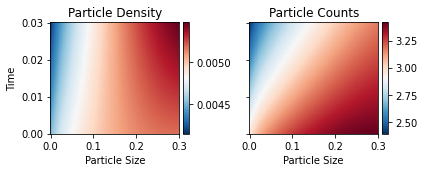

In [27]:
fig

### Low Variance Attempt (Higher IC Weight)
This attempt trains a network with the full gradients and a 100 points per interval.

In [28]:
n_i = 4
n_j = 100
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 10.0
w_tot = 0.1
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/08_lvmse_{timestamp}'
fig = train()

Epoch 0, loss = 7.2079 +/- 0.0000, loss_sm = 0.0393 +/- 0.0000, loss_ic = 7.1687 +/- 0.0000, integ_var = 0.0035 +/- 0.0000
Epoch 1000, loss = 3.0984 +/- 0.0000, loss_sm = 0.1897 +/- 0.0125, loss_ic = 2.9088 +/- 0.0000, integ_var = 0.4233 +/- 0.0290
Epoch 2000, loss = 1.3157 +/- 0.0000, loss_sm = 0.2036 +/- 0.0089, loss_ic = 1.1121 +/- 0.0000, integ_var = 1.0635 +/- 0.0580
Epoch 3000, loss = 0.6092 +/- 0.0000, loss_sm = 0.1758 +/- 0.0056, loss_ic = 0.4333 +/- 0.0000, integ_var = 1.8204 +/- 0.0749
Epoch 4000, loss = 0.3069 +/- 0.0000, loss_sm = 0.1334 +/- 0.0035, loss_ic = 0.1735 +/- 0.0000, integ_var = 2.5322 +/- 0.0889
Epoch 5000, loss = 0.1575 +/- 0.0000, loss_sm = 0.0873 +/- 0.0020, loss_ic = 0.0702 +/- 0.0000, integ_var = 3.0419 +/- 0.0908
Epoch 6000, loss = 0.0786 +/- 0.0000, loss_sm = 0.0505 +/- 0.0011, loss_ic = 0.0281 +/- 0.0000, integ_var = 3.3333 +/- 0.0878
Epoch 7000, loss = 0.0405 +/- 0.0000, loss_sm = 0.0291 +/- 0.0005, loss_ic = 0.0114 +/- 0.0000, integ_var = 3.4913 +/- 0.

Epoch 65000, loss = 0.0063 +/- 0.0003, loss_sm = 0.0059 +/- 0.0003, loss_ic = 0.0004 +/- 0.0000, integ_var = 3.7153 +/- 0.0812
Epoch 66000, loss = 0.0062 +/- 0.0002, loss_sm = 0.0058 +/- 0.0002, loss_ic = 0.0004 +/- 0.0000, integ_var = 3.7098 +/- 0.0744
Epoch 67000, loss = 0.0061 +/- 0.0002, loss_sm = 0.0057 +/- 0.0002, loss_ic = 0.0004 +/- 0.0000, integ_var = 3.7625 +/- 0.0787
Epoch 68000, loss = 0.0058 +/- 0.0003, loss_sm = 0.0055 +/- 0.0003, loss_ic = 0.0004 +/- 0.0000, integ_var = 3.7218 +/- 0.0728
Epoch 69000, loss = 0.0060 +/- 0.0003, loss_sm = 0.0057 +/- 0.0003, loss_ic = 0.0004 +/- 0.0000, integ_var = 3.7587 +/- 0.0787
Epoch 70000, loss = 0.0060 +/- 0.0003, loss_sm = 0.0057 +/- 0.0003, loss_ic = 0.0004 +/- 0.0000, integ_var = 3.7331 +/- 0.0740
Epoch 71000, loss = 0.0061 +/- 0.0003, loss_sm = 0.0058 +/- 0.0003, loss_ic = 0.0004 +/- 0.0000, integ_var = 3.6921 +/- 0.0763
Epoch 72000, loss = 0.0061 +/- 0.0003, loss_sm = 0.0057 +/- 0.0003, loss_ic = 0.0004 +/- 0.0000, integ_var = 3.

Epoch 130000, loss = 0.0055 +/- 0.0002, loss_sm = 0.0053 +/- 0.0002, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.7459 +/- 0.0732
Epoch 131000, loss = 0.0057 +/- 0.0002, loss_sm = 0.0054 +/- 0.0002, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.7308 +/- 0.0748
Epoch 132000, loss = 0.0055 +/- 0.0002, loss_sm = 0.0053 +/- 0.0002, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.7400 +/- 0.0781
Epoch 133000, loss = 0.0057 +/- 0.0002, loss_sm = 0.0054 +/- 0.0002, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.6822 +/- 0.0695
Epoch 134000, loss = 0.0055 +/- 0.0002, loss_sm = 0.0053 +/- 0.0002, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.7183 +/- 0.0719
Epoch 135000, loss = 0.0056 +/- 0.0002, loss_sm = 0.0053 +/- 0.0002, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.7229 +/- 0.0779
Epoch 136000, loss = 0.0057 +/- 0.0003, loss_sm = 0.0054 +/- 0.0003, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.7017 +/- 0.0744
Epoch 137000, loss = 0.0058 +/- 0.0003, loss_sm = 0.0055 +/- 0.0003, loss_ic = 0.0003 +/- 0.0000, integ_

Epoch 195000, loss = 0.0055 +/- 0.0002, loss_sm = 0.0052 +/- 0.0002, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.7172 +/- 0.0789
Epoch 196000, loss = 0.0056 +/- 0.0003, loss_sm = 0.0053 +/- 0.0003, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.6937 +/- 0.0759
Epoch 197000, loss = 0.0055 +/- 0.0002, loss_sm = 0.0052 +/- 0.0002, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.6564 +/- 0.0734
Epoch 198000, loss = 0.0055 +/- 0.0002, loss_sm = 0.0052 +/- 0.0002, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.6490 +/- 0.0736
Epoch 199000, loss = 0.0057 +/- 0.0003, loss_sm = 0.0054 +/- 0.0003, loss_ic = 0.0003 +/- 0.0000, integ_var = 3.6454 +/- 0.0713


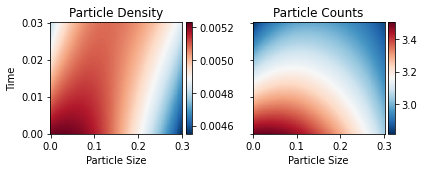

In [29]:
fig

# Third Problem

In [30]:
"""
This setting has a long x tail with zero kernel and thus no time derivates.
The long kernel-less tak makes R high, since uniform sampling of j for the 
outflux calculation generates lots of zero values.
   E_{xi}[Var_{xj}(d\rho/dt)] = 3.6
   E_{xi}[  E_{xj}[d\rho/dt]] = 0.5
   -> R = 6.91
"""

d = 1
n_gpd = 200
x_high = torch.tensor([1.0]*d, dtype=tch_dtype, device=tch_device)
get_kernel = CustomKernel(pnorm=.5, maxnorm=0.5, scale=5.0, 
    alpha=-5.0, beta=-0.33, gamma=-0.15)
get_rhoinit = RhoLin(rho1=3.0, rho2=1.0, x_high=x_high)
t_high = 1.0
dt_g = t_high / 100.0
ker_name, rhoi_name = 'harmonic_C', 'lin_C'

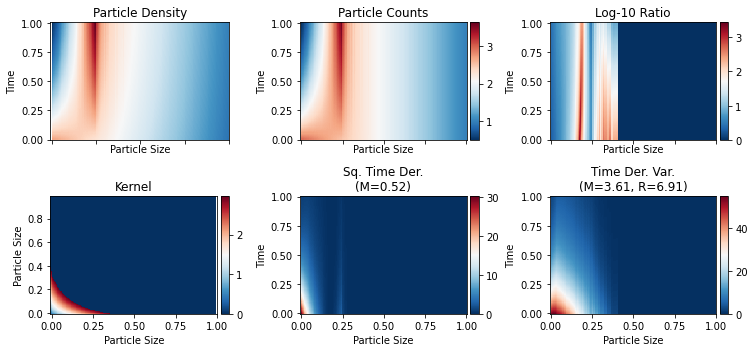

In [31]:
# Plotting the true solution (Euler integration through time)
fig = plot_true_solution()

### High Variance Attempt
This attempt trains a network with the full gradients and a 1 points per interval.

In [32]:
n_i = 400
n_j = 1
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 1.0
w_tot = 1.0
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/09_hvmse_{timestamp}'
fig = train()

Epoch 0, loss = 2.1506 +/- 0.0000, loss_sm = 0.0353 +/- 0.0000, loss_ic = 2.1153 +/- 0.0000
Epoch 1000, loss = 1.2744 +/- 0.0000, loss_sm = 0.1848 +/- 0.0080, loss_ic = 1.0896 +/- 0.0000
Epoch 2000, loss = 0.8931 +/- 0.0000, loss_sm = 0.2197 +/- 0.0056, loss_ic = 0.6733 +/- 0.0000
Epoch 3000, loss = 0.7488 +/- 0.0000, loss_sm = 0.2321 +/- 0.0044, loss_ic = 0.5167 +/- 0.0000
Epoch 4000, loss = 0.6951 +/- 0.0000, loss_sm = 0.2370 +/- 0.0037, loss_ic = 0.4581 +/- 0.0000
Epoch 5000, loss = 0.6698 +/- 0.0000, loss_sm = 0.2400 +/- 0.0035, loss_ic = 0.4299 +/- 0.0000
Epoch 6000, loss = 0.6624 +/- 0.0026, loss_sm = 0.2407 +/- 0.0034, loss_ic = 0.4217 +/- 0.0000
Epoch 7000, loss = 0.6542 +/- 0.0031, loss_sm = 0.2391 +/- 0.0032, loss_ic = 0.4151 +/- 0.0013
Epoch 8000, loss = 0.6491 +/- 0.0031, loss_sm = 0.2379 +/- 0.0030, loss_ic = 0.4112 +/- 0.0019
Epoch 9000, loss = 0.6510 +/- 0.0045, loss_sm = 0.2372 +/- 0.0031, loss_ic = 0.4138 +/- 0.0032
Epoch 10000, loss = 0.6495 +/- 0.0043, loss_sm = 0.23

Epoch 86000, loss = 0.6427 +/- 0.0045, loss_sm = 0.2294 +/- 0.0030, loss_ic = 0.4134 +/- 0.0028
Epoch 87000, loss = 0.6446 +/- 0.0045, loss_sm = 0.2304 +/- 0.0032, loss_ic = 0.4142 +/- 0.0026
Epoch 88000, loss = 0.6435 +/- 0.0044, loss_sm = 0.2305 +/- 0.0030, loss_ic = 0.4130 +/- 0.0026
Epoch 89000, loss = 0.6446 +/- 0.0045, loss_sm = 0.2298 +/- 0.0030, loss_ic = 0.4149 +/- 0.0029
Epoch 90000, loss = 0.6408 +/- 0.0035, loss_sm = 0.2287 +/- 0.0029, loss_ic = 0.4121 +/- 0.0019
Epoch 91000, loss = 0.6418 +/- 0.0043, loss_sm = 0.2294 +/- 0.0031, loss_ic = 0.4124 +/- 0.0023
Epoch 92000, loss = 0.6425 +/- 0.0042, loss_sm = 0.2303 +/- 0.0032, loss_ic = 0.4123 +/- 0.0021
Epoch 93000, loss = 0.6430 +/- 0.0041, loss_sm = 0.2299 +/- 0.0031, loss_ic = 0.4131 +/- 0.0024
Epoch 94000, loss = 0.6421 +/- 0.0041, loss_sm = 0.2292 +/- 0.0029, loss_ic = 0.4129 +/- 0.0025
Epoch 95000, loss = 0.6458 +/- 0.0047, loss_sm = 0.2317 +/- 0.0033, loss_ic = 0.4141 +/- 0.0025
Epoch 96000, loss = 0.6417 +/- 0.0039, l

Epoch 171000, loss = 0.6482 +/- 0.0048, loss_sm = 0.2305 +/- 0.0031, loss_ic = 0.4177 +/- 0.0030
Epoch 172000, loss = 0.6477 +/- 0.0044, loss_sm = 0.2318 +/- 0.0032, loss_ic = 0.4159 +/- 0.0023
Epoch 173000, loss = 0.6436 +/- 0.0041, loss_sm = 0.2295 +/- 0.0031, loss_ic = 0.4141 +/- 0.0023
Epoch 174000, loss = 0.6461 +/- 0.0047, loss_sm = 0.2308 +/- 0.0031, loss_ic = 0.4152 +/- 0.0029
Epoch 175000, loss = 0.6463 +/- 0.0045, loss_sm = 0.2309 +/- 0.0032, loss_ic = 0.4154 +/- 0.0026
Epoch 176000, loss = 0.6442 +/- 0.0039, loss_sm = 0.2312 +/- 0.0030, loss_ic = 0.4130 +/- 0.0022
Epoch 177000, loss = 0.6460 +/- 0.0041, loss_sm = 0.2311 +/- 0.0031, loss_ic = 0.4149 +/- 0.0023
Epoch 178000, loss = 0.6442 +/- 0.0042, loss_sm = 0.2303 +/- 0.0031, loss_ic = 0.4139 +/- 0.0024
Epoch 179000, loss = 0.6453 +/- 0.0043, loss_sm = 0.2311 +/- 0.0031, loss_ic = 0.4143 +/- 0.0024
Epoch 180000, loss = 0.6455 +/- 0.0048, loss_sm = 0.2294 +/- 0.0031, loss_ic = 0.4161 +/- 0.0032
Epoch 181000, loss = 0.6436 +/

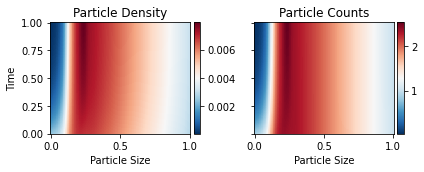

In [33]:
fig

### Low Variance Attempt
This attempt trains a network with the full gradients and a 100 points per interval.

In [34]:
n_i = 4
n_j = 100
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 1.0
w_tot = 1.0
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/10_lvmse_{timestamp}'
fig = train()

Epoch 0, loss = 2.0780 +/- 0.0000, loss_sm = 0.0007 +/- 0.0000, loss_ic = 2.0772 +/- 0.0000, integ_var = 0.0211 +/- 0.0000
Epoch 1000, loss = 1.0133 +/- 0.0000, loss_sm = 0.1474 +/- 0.0130, loss_ic = 0.8659 +/- 0.0000, integ_var = 1.2615 +/- 0.1008
Epoch 2000, loss = 0.4690 +/- 0.0000, loss_sm = 0.1176 +/- 0.0080, loss_ic = 0.3514 +/- 0.0000, integ_var = 2.0069 +/- 0.1286
Epoch 3000, loss = 0.2402 +/- 0.0000, loss_sm = 0.0924 +/- 0.0056, loss_ic = 0.1478 +/- 0.0000, integ_var = 2.4008 +/- 0.1376
Epoch 4000, loss = 0.1476 +/- 0.0039, loss_sm = 0.0826 +/- 0.0056, loss_ic = 0.0650 +/- 0.0000, integ_var = 2.6791 +/- 0.1472
Epoch 5000, loss = 0.0986 +/- 0.0034, loss_sm = 0.0690 +/- 0.0041, loss_ic = 0.0296 +/- 0.0000, integ_var = 2.8276 +/- 0.1461
Epoch 6000, loss = 0.0791 +/- 0.0038, loss_sm = 0.0630 +/- 0.0040, loss_ic = 0.0162 +/- 0.0000, integ_var = 2.7768 +/- 0.1381
Epoch 7000, loss = 0.0689 +/- 0.0036, loss_sm = 0.0582 +/- 0.0036, loss_ic = 0.0107 +/- 0.0003, integ_var = 2.9343 +/- 0.

Epoch 65000, loss = 0.0401 +/- 0.0031, loss_sm = 0.0372 +/- 0.0031, loss_ic = 0.0029 +/- 0.0002, integ_var = 3.2397 +/- 0.1647
Epoch 66000, loss = 0.0419 +/- 0.0031, loss_sm = 0.0389 +/- 0.0031, loss_ic = 0.0030 +/- 0.0002, integ_var = 3.2146 +/- 0.1499
Epoch 67000, loss = 0.0410 +/- 0.0032, loss_sm = 0.0380 +/- 0.0031, loss_ic = 0.0030 +/- 0.0002, integ_var = 3.2901 +/- 0.1541
Epoch 68000, loss = 0.0387 +/- 0.0027, loss_sm = 0.0362 +/- 0.0027, loss_ic = 0.0025 +/- 0.0002, integ_var = 3.2168 +/- 0.1521
Epoch 69000, loss = 0.0404 +/- 0.0029, loss_sm = 0.0377 +/- 0.0029, loss_ic = 0.0027 +/- 0.0002, integ_var = 3.2890 +/- 0.1539
Epoch 70000, loss = 0.0391 +/- 0.0028, loss_sm = 0.0364 +/- 0.0028, loss_ic = 0.0027 +/- 0.0002, integ_var = 3.2444 +/- 0.1548
Epoch 71000, loss = 0.0405 +/- 0.0034, loss_sm = 0.0374 +/- 0.0033, loss_ic = 0.0030 +/- 0.0002, integ_var = 3.1677 +/- 0.1541
Epoch 72000, loss = 0.0386 +/- 0.0028, loss_sm = 0.0359 +/- 0.0028, loss_ic = 0.0027 +/- 0.0002, integ_var = 3.

Epoch 130000, loss = 0.0410 +/- 0.0030, loss_sm = 0.0382 +/- 0.0029, loss_ic = 0.0028 +/- 0.0002, integ_var = 3.2248 +/- 0.1458
Epoch 131000, loss = 0.0388 +/- 0.0027, loss_sm = 0.0364 +/- 0.0027, loss_ic = 0.0025 +/- 0.0002, integ_var = 3.2201 +/- 0.1464
Epoch 132000, loss = 0.0389 +/- 0.0030, loss_sm = 0.0363 +/- 0.0030, loss_ic = 0.0026 +/- 0.0002, integ_var = 3.2556 +/- 0.1537
Epoch 133000, loss = 0.0385 +/- 0.0031, loss_sm = 0.0361 +/- 0.0031, loss_ic = 0.0024 +/- 0.0002, integ_var = 3.2153 +/- 0.1449
Epoch 134000, loss = 0.0387 +/- 0.0027, loss_sm = 0.0362 +/- 0.0027, loss_ic = 0.0025 +/- 0.0002, integ_var = 3.2642 +/- 0.1479
Epoch 135000, loss = 0.0381 +/- 0.0027, loss_sm = 0.0357 +/- 0.0027, loss_ic = 0.0024 +/- 0.0002, integ_var = 3.2261 +/- 0.1556
Epoch 136000, loss = 0.0364 +/- 0.0028, loss_sm = 0.0340 +/- 0.0028, loss_ic = 0.0023 +/- 0.0002, integ_var = 3.1715 +/- 0.1519
Epoch 137000, loss = 0.0391 +/- 0.0030, loss_sm = 0.0365 +/- 0.0030, loss_ic = 0.0025 +/- 0.0002, integ_

Epoch 197000, loss = 0.0387 +/- 0.0034, loss_sm = 0.0362 +/- 0.0034, loss_ic = 0.0025 +/- 0.0002, integ_var = 3.0970 +/- 0.1507
Epoch 198000, loss = 0.0361 +/- 0.0029, loss_sm = 0.0337 +/- 0.0029, loss_ic = 0.0024 +/- 0.0002, integ_var = 3.0425 +/- 0.1409
Epoch 199000, loss = 0.0379 +/- 0.0030, loss_sm = 0.0355 +/- 0.0030, loss_ic = 0.0024 +/- 0.0002, integ_var = 3.0642 +/- 0.1528


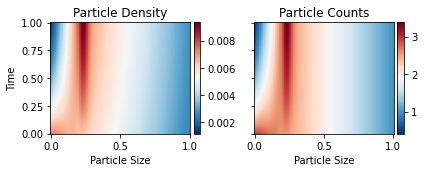

In [35]:
fig

### High Variance Attempt (Higher IC Weight)
This attempt trains a network with the full gradients and a 1 points per interval.

In [36]:
n_i = 400
n_j = 1
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
n_gpd_plt = 200
w_ic = 10.0
w_tot = 0.1
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/11_hvmse_{timestamp}'
fig = train()

Epoch 0, loss = 2.1188 +/- 0.0000, loss_sm = 0.0035 +/- 0.0000, loss_ic = 2.1153 +/- 0.0000
Epoch 1000, loss = 0.9438 +/- 0.0000, loss_sm = 0.1141 +/- 0.0054, loss_ic = 0.8297 +/- 0.0000
Epoch 2000, loss = 0.4530 +/- 0.0000, loss_sm = 0.1264 +/- 0.0029, loss_ic = 0.3265 +/- 0.0000
Epoch 3000, loss = 0.2715 +/- 0.0000, loss_sm = 0.1305 +/- 0.0021, loss_ic = 0.1410 +/- 0.0000
Epoch 4000, loss = 0.2059 +/- 0.0000, loss_sm = 0.1327 +/- 0.0018, loss_ic = 0.0732 +/- 0.0000
Epoch 5000, loss = 0.1799 +/- 0.0000, loss_sm = 0.1326 +/- 0.0016, loss_ic = 0.0473 +/- 0.0000
Epoch 6000, loss = 0.1715 +/- 0.0000, loss_sm = 0.1332 +/- 0.0017, loss_ic = 0.0383 +/- 0.0000
Epoch 7000, loss = 0.1668 +/- 0.0010, loss_sm = 0.1325 +/- 0.0016, loss_ic = 0.0343 +/- 0.0000
Epoch 8000, loss = 0.1645 +/- 0.0013, loss_sm = 0.1319 +/- 0.0015, loss_ic = 0.0326 +/- 0.0001
Epoch 9000, loss = 0.1657 +/- 0.0018, loss_sm = 0.1330 +/- 0.0017, loss_ic = 0.0327 +/- 0.0004
Epoch 10000, loss = 0.1655 +/- 0.0017, loss_sm = 0.13

Epoch 86000, loss = 0.1635 +/- 0.0018, loss_sm = 0.1322 +/- 0.0017, loss_ic = 0.0313 +/- 0.0003
Epoch 87000, loss = 0.1637 +/- 0.0017, loss_sm = 0.1324 +/- 0.0017, loss_ic = 0.0313 +/- 0.0002
Epoch 88000, loss = 0.1632 +/- 0.0017, loss_sm = 0.1321 +/- 0.0016, loss_ic = 0.0311 +/- 0.0003
Epoch 89000, loss = 0.1641 +/- 0.0018, loss_sm = 0.1326 +/- 0.0016, loss_ic = 0.0314 +/- 0.0003
Epoch 90000, loss = 0.1627 +/- 0.0014, loss_sm = 0.1316 +/- 0.0015, loss_ic = 0.0311 +/- 0.0002
Epoch 91000, loss = 0.1631 +/- 0.0016, loss_sm = 0.1318 +/- 0.0016, loss_ic = 0.0313 +/- 0.0003
Epoch 92000, loss = 0.1630 +/- 0.0016, loss_sm = 0.1318 +/- 0.0016, loss_ic = 0.0312 +/- 0.0002
Epoch 93000, loss = 0.1628 +/- 0.0016, loss_sm = 0.1318 +/- 0.0016, loss_ic = 0.0310 +/- 0.0002
Epoch 94000, loss = 0.1631 +/- 0.0017, loss_sm = 0.1319 +/- 0.0016, loss_ic = 0.0313 +/- 0.0003
Epoch 95000, loss = 0.1634 +/- 0.0016, loss_sm = 0.1323 +/- 0.0016, loss_ic = 0.0311 +/- 0.0002
Epoch 96000, loss = 0.1631 +/- 0.0017, l

Epoch 171000, loss = 0.1653 +/- 0.0019, loss_sm = 0.1336 +/- 0.0018, loss_ic = 0.0318 +/- 0.0003


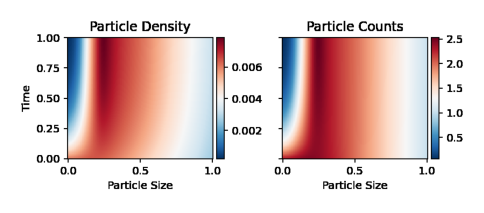

In [37]:
fig

### Low Variance Attempt (Higher IC Weight)
This attempt trains a network with the full gradients and a 100 points per interval.

# Fourth Problem

In [38]:
"""
This setting has a long x tail with zero kernel and thus no time derivates.
The long kernel-less tak makes R high, since uniform sampling of j for the 
outflux calculation generates lots of zero values.
   E_{xi}[Var_{xj}(d\rho/dt)] = 0.51
   E_{xi}[  E_{xj}[d\rho/dt]] = 0.08
   -> R = 6.14
"""
d = 1
n_gpd = 100
x_high = torch.tensor([1.0]*d, dtype=tch_dtype, device=tch_device)
get_kernel = CustomKernel(pnorm=.5, maxnorm=0.5, scale=6.5, 
    alpha=-3.0, beta=-0.33, gamma=-0.15)
get_rhoinit = RhoLin(rho1=1.0, rho2=1.0, x_high=x_high)
t_high = 0.01
dt_g = t_high / 100.0

ker_name, rhoi_name = 'harmonic_D', 'lin_D'

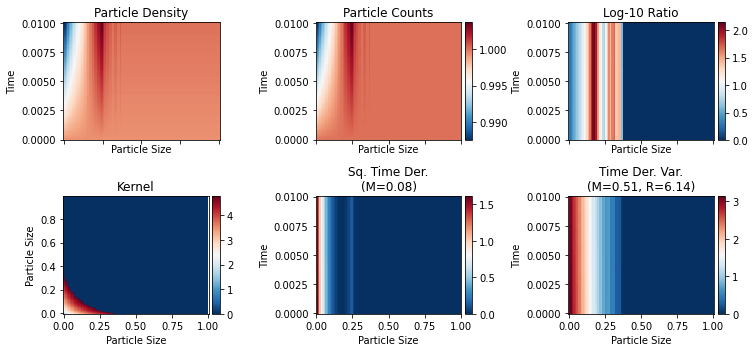

In [39]:
# Plotting the true solution (Euler integration through time)
fig = plot_true_solution()